# <h1 align="center"><font color="gree">Qwen2-VL: Hands-On Guides for Invoice Data Extraction, Video Chatting, and Multimodal RAG with PDFs</font></h1>

<font color="pink">Senior Data Scientist.: Dr. Eddy Giusepe Chirinos Isidro</font>

Este Notebook segue o tutorial de [Nikos Kafritsas](https://aihorizonforecast.substack.com/p/qwen2-vl-hands-on-guides-for-invoice). 

# <font color="red">Como usar um modelo de linguagem de visão de código aberto de ponta?</font>

<font color="orange">A imagem abaixo mostra a `arquitetura` de nível superior do `Qwen2-VL`</font>


O que se sabe até agora é que o `Qwen2-VL` usa o `Qwen2-LM` com um `Vision Transformer` — capaz de processar `imagens` e `vídeos`.

Além disso, o `Qwen2-VL` introduz o novo `Multimodal Rotary Position Embeddings` (**M-ROPE**). Essa é uma variante dos `embeddings ROPE` (nós os discutimos brevemente [aqui](https://aihorizonforecast.substack.com/p/moirai-salesforces-foundation-transformer)) que decompõe os embeddings posicionais em partes — capturando `texto 1D`, `visual 2D` e `vídeo 3D`:

![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fbf04e083-f0ef-4a9b-8784-ebecbfc52a78_1634x412.png)

`Qwen2-VL` suporta vários idiomas, incluindo a maioria dos `idiomas europeus`, `japonês`, `coreano`, `chinês` e `árabe`. Mais detalhes estarão disponíveis quando o artigo oficial for lançado.


<font color="red">Nota:</font>

`Qwen2-VL` vem em 3 tamanhos: `Qwen2-VL-2B`, `Qwen2-VL-7B` e `Qwen2-VL-72B`. As versões `2B` e `7B` são totalmente de `código aberto` (`Licença Apache`). A versão `72B é comercial`, mas gratuita para serviços com menos de 100 milhões de usuários ativos mensais.


![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Ffe3c34e0-f1e9-4fc8-9c73-915794e384e5_1656x1076.png)

O aumento de novos `LLMs` e `vLLMs` é imparável. Um modelo notável é o `Qwen2-VL` — um `Vision LM` com compreensão avançada de `imagem` e `vídeo`.

Principais características do `Qwen2-VL`:

* `Arquitetura poderosa:` Lançado pela `Alibaba`, é construído no Qwen2 LM.

* `Reconhecimento de objetos e textos:` O `Qwen2-VL` reconhece relacionamentos complexos de objetos, textos manuscritos e vários idiomas.

* `Raciocínio visual aprimorado:` o modelo resolve problemas de `matemática` e `codificação` a partir de gráficos e imagens, melhorando a extração de dados do mundo real.

* `Compreensão de vídeo e bate-papo ao vivo:` fornece resumo de vídeo, resposta a perguntas e suporte por bate-papo em tempo real a partir de conteúdo de vídeo.

* `Chamada de função (Function calling) e interações visuais:` o `Qwen2-VL` recupera dados em tempo real por meio de indicações visuais, como atualizações meteorológicas.



Aqui seguimos o tutorial de `Nikos Kafritsas`, quem apresenta `3` guias práticos para usar o `Qwen2-VL`. Esses são:

`1.` Extração de dados de imagem

`2.` Conversando com vídeos

`3.` RAG multimodal com PDFs

# <font color="blue">`Project 1:` Invoice Data Extraction to JSON Format</font>

Neste miniprojeto, extrairemos informações financeiras e pessoais de uma fatura — no formato `JSON`.

Bibliotecas necessárias:

```
pip install git+https://github.com/huggingface/transformers accelerate

pip install qwen-vl-utils
```

Em seguida, baixamos nosso arquivo:

In [ ]:
import urllib.request

# We will use this sample invoice:
url = "https://www.zoho.com/invoice/images/invoice-templates/service-invoice-template/service-invoice-template-1x.jpg"

# Download the file:
file_name = url.split('/')[-1]
urllib.request.urlretrieve(url, file_name)

print(f"Downloaded file name: {file_name}")
# Downloaded file name: service-invoice-template-1x.jpg

Em seguida, instalaremos `Qwen2-VL-2B-Instruct` — a versão menor, menos precisa, mas compatível com `VRAM` para execução no Colab.

Sinta-se à vontade para tentar `Qwen2-VL-7B-Instruct` se você tiver uma `GPU` maior.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import json

model_name = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(
    model_name
)

Após o modelo ser baixado e colocado na memória, podemos enviar nossa solicitação. Algumas dicas extras:

Use pelo menos as dimensões originais da imagem : certifique-se de usar pelo menos o tamanho original da sua imagem para obter melhores resultados ( resized_height e resized_width arguments abaixo)

Dimensões maiores : Tamanhos de dimensões ligeiramente maiores em imagens de baixa qualidade podem melhorar a precisão, mas aumentarão o uso de VRAM. Ajuste de acordo:

Usaremos o modelo de bate-papo do Qwen2-VL com o seguinte prompt:

```
"Retrieve invoice_number, date_of_issue, seller_info, client_info, invoice_items_table, invoice_summary_table. Response must be in JSON format"
```
ou em português:

```
Recuperar invoice_number, date_of_issue, seller_info, client_info, invoice_items_table, invoice_summary_table. A resposta deve estar no formato JSON
```

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": file_name,
                "resized_height": 696,
                "resized_width": 943,
            },
            {
                "type": "text",
                "text": """Recuperar invoice_number, date_of_issue, seller_info, client_info,
                           invoice_items_table, invoice_summary_table. A resposta deve estar
                           no formato JSON"""
            }
        ]
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

generated_ids = model.generate(**inputs, max_new_tokens=512)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=True)

output_text

<font color="orange">Você pode usar o código abaixo para corrigir possíveis erros e formatar a saída `JSON` do modelo:</font>

In [ ]:
json_string = output_text[0]

json_string = json_string.strip("[]'")
json_string = json_string.replace("```json\n", "").replace("\n```", "")
json_string = json_string.replace("'", "")

try:
    formatted_json = json.loads(json_string)
    print(json.dumps(formatted_json, indent=3))
except json.JSONDecodeError as e:
    print("Not valid JSON format:", e)

Comparando os resultados com a fatura (`invoice`) acima, notamos:

* A saída do modelo é impecável — ele extrai todas as informações relevantes com precisão!

* Isso ocorreu apesar da baixa qualidade da imagem e dos dados incorporados nas tabelas!

* O `Qwen2-VL` menor teve um bom desempenho aqui, mas para imagens mais complexas ou texto manuscrito, você pode precisar de modelos maiores como `Qwen2-VL-7B`.

# <font color="blue">`Project 2:` Chat with Video</font>

O `Qwen2-VL` também pode extrair informações e interagir com vídeos.

Para este projeto, usaremos um pequeno vídeo do `YouTube` — uma cena famosa de Pulp Fiction com a dança de John Travolta e Uma Thurman:


Library for downloading youtube videos:
```
%pip install pytubefix
```

<iframe width="560" height="315" src="https://www.youtube.com/embed/6MUy21DdnSc?controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>

<font color="orange">Faça o download da seguinte forma:</font>

In [ ]:
from pytubefix import YouTube
from pytubefix.cli import on_progress

file_name = "youtube_short.mp4"

url = "https://youtube.com/shorts/6MUy21DdnSc?si=-GofdpXBc97pTQ-E"

yt = YouTube(url, on_progress_callback = on_progress)
print(yt.title)

ys = yt.streams.get_highest_resolution()
ys.download(filename=file_name)

In [1]:
file_name = "youtube_short.mp4"

<font color="orange">Usaremos `Qwen2-VL-2B` novamente, pois consome menos recursos.</font>

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import json

model_name = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
     model_name,
     torch_dtype="auto",
     ##attn_implementation="flash_attention_2", #use flash-attention2 if your gpu card supports it (Free Colab's T4 does not support it)
     device_map="cuda:0", #"auto",
)

processor = AutoProcessor.from_pretrained(
    model_name
)

Definimos a função `chat_with_video`, que pega as `dimensões` do vídeo `redimensionado`, framess por segundo e a mensagem de texto que perguntaremos a `Qwen`:

In [3]:
def chat_with_video(file_name, query, video_width, video_height, fps=1.0):

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "video",
                    "video": file_name,
                    "max_pixels": video_width * video_height,
                    "fps": 1.0,
                },
                {"type": "text", "text": query},
            ],
        }
    ]


    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )


    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )

    inputs = inputs.to("cuda")
    #inputs = inputs.to("cpu")


    generated_ids = model.generate(**inputs, max_new_tokens=150)

    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

<font color="orange">Vamos perguntar ao modelo:</font>

In [4]:
import warnings
warnings.simplefilter("ignore")


In [ ]:
output_text = chat_with_video(file_name, "O que esse vídeo mostra?", 360, 360)

output_text

<font color="orange">E outra pergunta:</font>

In [ ]:
output_text = chat_with_video(file_name, "A mulher no vídeo está usando sapatos?", 360, 420 )

<font color="orange">Surpreendentemente, a modelo respondeu ambas as perguntas com precisão!

`Algumas observações adicionais:`

* Aumentar a altura, a largura e a taxa de frames (`fps`) do vídeo geralmente melhora a precisão, mas requer mais `GPU VRAM`.

* O `Qwen2-VL` pode processar vídeos com mais de `20 minutos`, mas ainda `não processa som`.

* Em meus experimentos, o `Qwen2-VL-7B` oferece o melhor equilíbrio entre precisão e requisitos de recursos (`GPU VRAM`).</font>

# <font color="blue">`Project 3:` Multimodal RAG</font>

Neste projeto, combinaremos o `Qwen2-VL` com outro modelo, `ColPali`, para executar `RAG` com `PDFs`.

`ColPali` é um modelo de recuperação (retrieval) de documentos que contém um modelo `PaliGemma-3B` (também `VLM`) e um `Gemma-2B`. A função do `ColPali` é executar a parte de recuperação de documentos e criar um repositório de documentos multivetorial:

![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F4434fdcd-312b-47fc-9d38-d8a5a5181902_985x593.png)

* `Imagem superior:` Os sistemas de recuperação tradicionais usam ferramentas de `OCR` para extrair texto de imagens e, posteriormente, dividir o texto em `embeddings` de texto.

* `Inferior: Imagem:` Em contraste, o `ColPali` executa `RAG` nos documentos visualmente (tratando a página do documento como uma imagem e dividindo-a em patches de imagem)

O `pipeline` no nosso caso é o seguinte:

* Converte cada página do `PDF` em uma imagem.

* Insira as imagens no `ColPali` para armazenar uma representação `multivetorial` para cada página.

* Envie uma consulta de texto ao `ColPali` para recuperar a(s) imagem(ns) relevante(s).

* Envie a consulta de texto e as imagens relevantes para o `Qwen2-VL` para obter a resposta.



Usaremos a biblioteca `Byaldi` para criar o `armazenamento de vetores de imagem`. O `Byaldi` carrega o `ColPali` (e modelos similares com a `API`). Também usaremos o `pdf2image` para converter o `PDF` em imagens.


Vamos começar instalando as bibliotecas necessárias:


```
#pip install --upgrade byaldi

pip install byaldi==0.0.5

pip install -q git+https://github.com/huggingface/transformers.git qwen-vl-utils pdf2image



## necessary tool for pdf2image

!sudo apt-get install -y poppler-utils
```

Baixaremos um [PDF de 4 páginas](https://studyingreece.edu.gr/wp-content/uploads/2024/05/AUEB-International-Partnerships.pdf) para este projeto — um arquivo pequeno para conservar `VRAM`.

In [ ]:
import urllib.request

# We will use this pdf:
url = "https://studyingreece.edu.gr/wp-content/uploads/2024/05/AUEB-International-Partnerships.pdf"

# Download the file:
pdf_filepath = url.split('/')[-1]

urllib.request.urlretrieve(url, pdf_filepath)

print(f"Downloaded file name: {pdf_filepath}")

In [1]:
pdf_filepath = "AUEB-International-Partnerships.pdf"

<font color="orange">`Como os modelos trabalham com imagens`, não com arquivos `PDF`, convertemos cada página em uma imagem. Se você quiser visualizar as imagens no `Jupyter/Colab`, execute este código:</font>

Page 1:


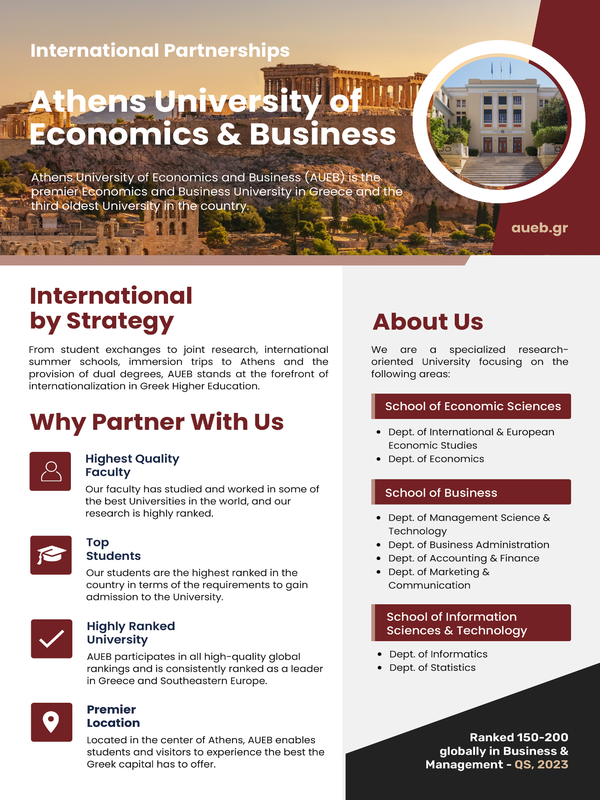

Page 2:


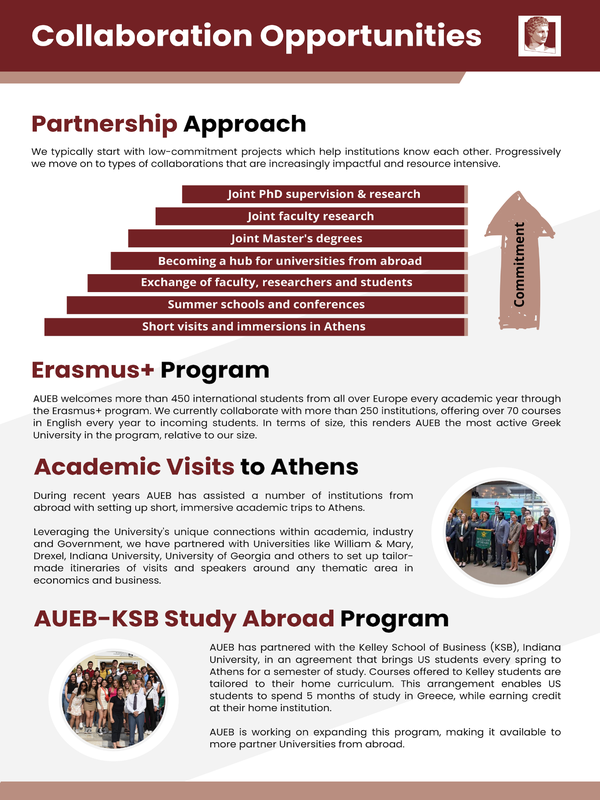

Page 3:


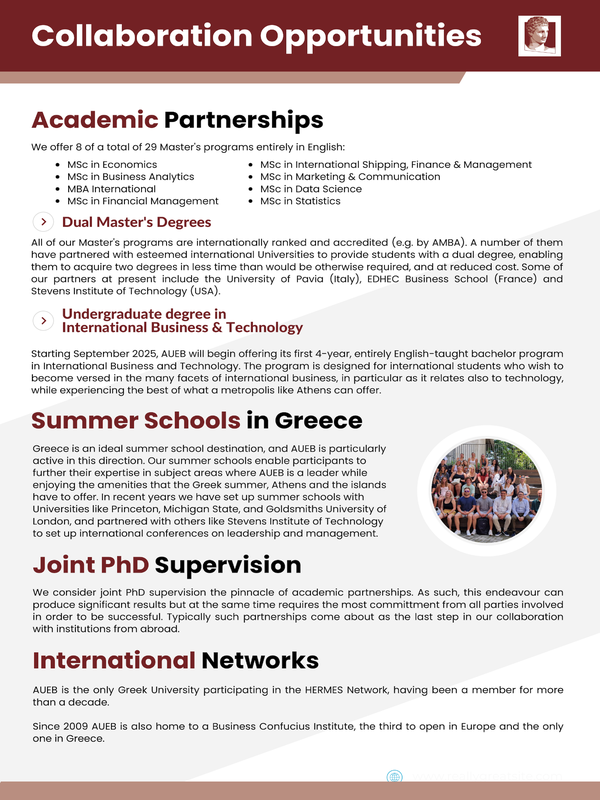

Page 4:


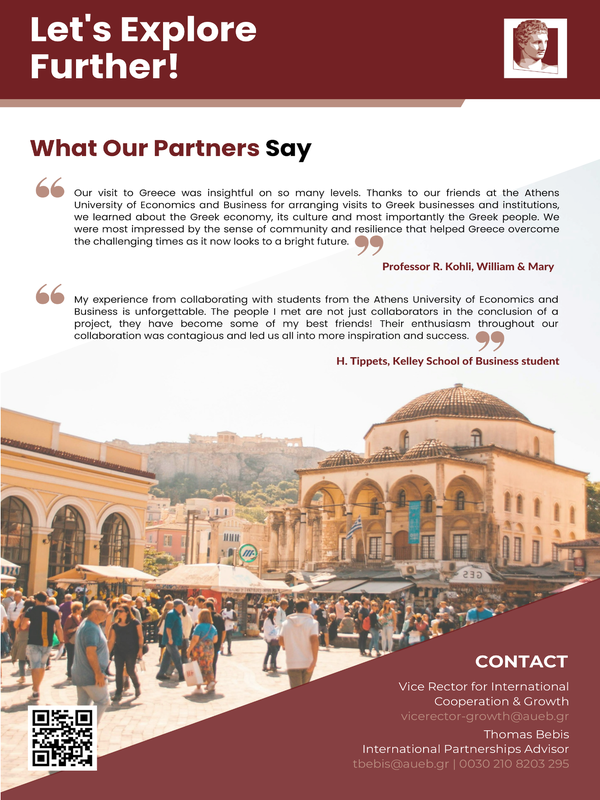

In [2]:
from PIL import Image as PILImage
from pdf2image import convert_from_path
from IPython.display import display

images = convert_from_path(pdf_filepath)

for page_number, page in enumerate(images):
    resized_image = page.resize((600, 800), PILImage.Resampling.LANCZOS)

    print(f"Page {page_number + 1}:")
    display(resized_image)

<font color="orange">Em seguida, carregamos o `ColPali` e construímos nosso armazenamento de índice:</font>

In [3]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

RAG.index(
    input_path=pdf_filepath,
    index_name="image_index", # index will be saved at .byaldi/index_name/
    store_collection_with_index=False,
    overwrite=True)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

overwrite is on. Deleting existing index image_index to build a new one.


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Added page 1 of document 0 to index.


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Added page 2 of document 0 to index.


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: 'AUEB-International-Partnerships.pdf'}

<font color="orange">O índice contém `4` imagens — uma por página do `PDF`. Agora, carregamos `Qwen2-VL-2B`:</font>

In [4]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch


vlm_name = "Qwen/Qwen2-VL-2B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(vlm_name,
                                                        torch_dtype="auto", # "auto"
                                                        device_map="cpu") # "auto"

processor = AutoProcessor.from_pretrained(vlm_name)

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A função `extract_answer_from_pdf` executa o seguinte:

`1.` Dada uma text-query, pedimos a `Colpali` para recuperar a imagem mais relevante (`k=1`). A imagem representa uma página `PDF`.

`2.` Dada uma text-query e a imagem relevante, pedimos ao `Qwen-VL-2B` para realizar o reconhecimento de imagem e fornecer uma resposta à nossa consulta de texto.

`3.` A função retorna a resposta (`output_text`), o número da página que continha a resposta e a imagem/página relevante.

In [5]:
def extract_answer_from_pdf(text_query):

  results = RAG.search(text_query, k=1)
  print(results)

  image_index = results[0]["page_num"] - 1
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": images[image_index], ## contains the retrieved pdf page as image
                  "resized_height": 527,
                  "resized_width": 522,
              },
              {"type": "text", "text": text_query},
          ],
      }
  ]

  text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
  )


  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cpu")

  generated_ids = model.generate(**inputs, max_new_tokens=50)
  ## remove the prompt from the answer
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  return output_text, results[0].page_num , images[image_index]



<font color="orange">Vamos perguntar ao nosso modelo:</font>

[{'doc_id': 0, 'page_num': 2, 'score': 19.25, 'metadata': {}, 'base64': None}]



['AUEB está localizada en la ciudad de Athens, Grecia.']
The answer is found in page 2 which is:


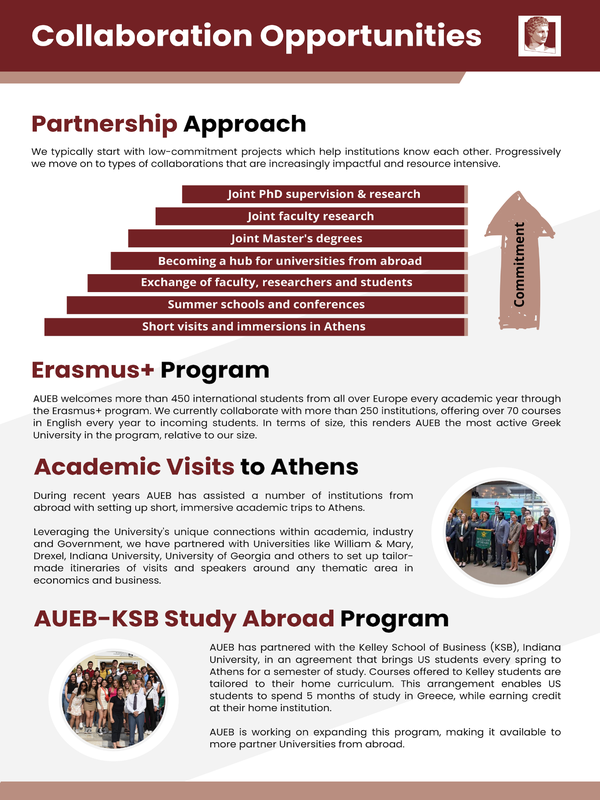

In [6]:
text_query = "Onde a AUEB está localizada?" #"Where AUEB is located?"
output_text, page_number, image =  extract_answer_from_pdf(text_query)

print("\n\n")
print(output_text)
print(f"The answer is found in page {page_number} which is:")
display(image.resize((600, 800), PILImage.Resampling.LANCZOS))

![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb2348446-109f-428a-b57e-1c74cdedca5d_600x800.png)

O modelo está correto! `A Universidade AUEB fica em Atenas, Grécia.` Curiosamente, a resposta foi sintetizada de diferentes partes do texto (observe os quadrados verdes)

Vamos fazer outra pergunta:

[{'doc_id': 0, 'page_num': 1, 'score': 18.0, 'metadata': {}, 'base64': None}]



['O programa foi classificado em 150-200 em Negócios e Gestão.']
The answer is found in page 1 which is:


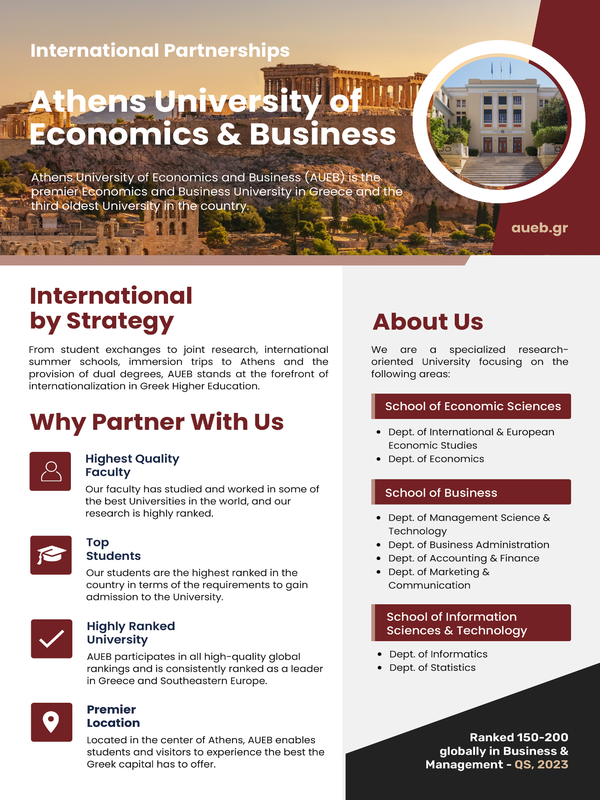

In [7]:
text_query = "Em que posição em Negócios e Gestão o programa foi classificado?" #"In which position in Business and Management did the program ranked?"
output_text, page_number, image =  extract_answer_from_pdf(text_query)

print("\n\n")
print(output_text)
print(f"The answer is found in page {page_number} which is:")
display(image.resize((600, 800), PILImage.Resampling.LANCZOS))

![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F2775280d-af6d-438e-8cf2-d1678fde60d4_600x800.png)

<font color="orange">O modelo está correto novamente, identificando a resposta no canto inferior direito da página 1.

Vamos fazer uma última pergunta:</font>

In [ ]:
text_query = "Qual é o endereço de e-mail e número de telefone de Thomas Bebis?" #"What is the email address and phone number of Thomas Bebis?"
output_text, page_number, image =  extract_answer_from_pdf(text_query)

print("\n\n")
print(output_text)
print(f"The answer is found in page {page_number} which is:")
display(image.resize((600, 800), PILImage.Resampling.LANCZOS))

![](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F0c36d227-e9a5-48a9-b2c9-caaf92786d15_600x800.png)

Corrija novamente. Sinta-se à vontade para experimentar o modelo e fazer suas perguntas. `Você pode tentar idiomas diferentes também!`

* `Podemos usar vários PDFs?`

Sim! Basta colocar vários PDFs na pasta que `RAG.index()` acessa.

* `Podemos recuperar mais de 1 imagem?`

Sim. Neste caso, recuperamos apenas a imagem mais relevante (`k=1`). Você pode recuperar mais definindo `k=2` e, em seguida, passar ambas as imagens para o Qwen para processamento.

In [ ]:
chat_template = [
  {
      "role": "user",
      "content": [
          {
           "type": "image",
           "image": image[0],
          },
          {
            "type": "image",
            "image": image[1],
          },
            {"type": "text", "text": text_query},
      ],
  }
]

`No entanto, adicionar mais PDFs ou recuperar várias páginas exige muito mais recursos.`

## <font color="gree">Comentários finais + bônus (Llama-Vision3.2)</font>

Este artigo explorou o `Qwen2-VL` para tarefas de `recuperação de imagens`, `vídeos` e `documentos`.

Para casos mais complexos, você pode optar pelas versões maiores ou quantizadas do modelo — elas são reduzidas em tamanho com perda mínima de qualidade. Você pode encontrá-los [aqui](https://huggingface.co/collections/Qwen/qwen2-vl-66cee7455501d7126940800d).

Outro caso de uso interessante para o `Qwen2-VL` é o `Fine_tuning` (que posso abordar em um artigo futuro).

Além disso, há outros `VLMs` notáveis ​​como [Llama3.2-Vision](https://huggingface.co/meta-llama/Llama-3.2-11B-Vision) e [Aria](https://huggingface.co/rhymes-ai/Aria), incluindo uma versão quantizada do `Llama3.2-11B-Vision`. Se você estiver fora da UE (sim, os regulamentos da UE proíbem os modelos multimodais do Meta), você também pode executar meu `notebook` `Llama-Vision3.2`, que está disponível junto com os projetos Qwen.